In [2]:
% matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d as mp3d
import math
import os
from io import BytesIO
from scipy.integrate import simps
from scipy.signal import correlate
from scipy.signal import fftconvolve
import scipy.signal as ss
from scipy.ndimage.filters import gaussian_filter 


In [35]:
def thresh_sample(v):
    m,s = v.mean(),v.std().apply(lambda x:.23*math.sqrt(x))
    tm,tM = m-s,m+s
    trunc_m = v[ v.apply(lambda x: x>tM,axis=1).sum(axis=1)!= 0]
    trunc_M = v[ v.apply(lambda x: x<tm,axis=1).sum(axis=1)!= 0]
    m_ind = min(trunc_m.index[0],trunc_M.index[0])
    M_ind = max(trunc_m.index[-1],trunc_M.index[-1])
    return v.ix[m_ind:M_ind,:]

"""
def norm_interp(v):
    def toax(a):
        xd = a.index
        xd = xd/float(xd[-1])*100
        return np.interp(range(100),xd,a)
    df = pd.DataFrame([ toax(v[a]) for a in v.columns ] ).T
    df.columns = ['x','y','z']
    m = df.mean()
    return df.apply(lambda x:x-m[x.name],axis=0)
"""

def normalize(v):
        v = v.apply(lambda x:gaussian_filter(x,sigma=4),axis=0)
        m,s = v.mean(),v.std()
        v = v.apply(lambda x:(x-m[x.name])/s[x.name],axis=0)
        v = v.reindex(range(512),fill_value=0)
        return v
    

    
def convolve(s1,s2):
    df = pd.DataFrame()
    for x in s1.columns:
        #df[x] = np.fft.ifft(np.fft.fft(s1[x])*np.fft.fft(s2[x])).real
        #df[x] = correlate(s1[x],s2[x])
        df[x] = fftconvolve(s1[x],s2[x])
    return df

 

In [37]:
filelist = [ x for x in os.listdir('./') if ('.txt' in x and '__2' in x) ]

In [38]:
# preprocessed signal

D = dict()
for f in filelist:
    with open(f) as fh:
        s = ''.join([ x for x in fh if (x[0]!='#' and x[0]!='\n')])
        D[f] = pd.read_csv(BytesIO(s),sep=' ',names=['x','y','z','v'],usecols=['x','y','z'])
        D[f] = thresh_sample(D[f]).reset_index(drop=True)
        D[f] = normalize(D[f])
        


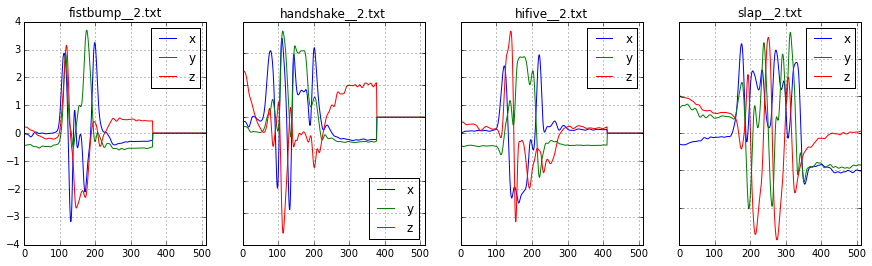

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(15,4))
for i,(k,v) in enumerate(sorted(D.items())):
    v.plot(title=k,ax=axes[i],xlim=(0,512),sharey=True)

In [40]:
for k,v in D.items():
    f = './training/'+k
    v.to_csv(f,header=False,index=False)


In [442]:
# convolution of pairs

convDict=dict()
for i1,(k1,v1) in enumerate(sorted(D.items())):
    for i2,(k2,v2) in enumerate(sorted(D.items())):
        if i2 <= i1:
            convDict[(k1,k2)] = convolve(v1,v2)

In [443]:
# a gesture paired with itself
diagKeys = [ k for k in convDict.keys() if k[0]==k[1] ]
# gesture-types
handshake = [ k for k in convDict.keys() if 'handshake' in k[0] and 'handshake' in k[1] ]
hifive = [ k for k in convDict.keys() if 'hifive' in k[0] and 'hifive' in k[1] ]
slap = [ k for k in convDict.keys() if 'slap' in k[0] and 'slap' in k[1] ]
fistbump = [ k for k in convDict.keys() if 'fistbump' in k[0] and 'fistbump' in k[1] ]
# all matching gesture types
matches = handshake + hifive + slap + fistbump
# non matching gesture types
nonmatch = set(convDict.keys()).difference(set(matches))

('slap__4.txt', 'slap.txt')
x    410
y    528
z    496
x    622.247684
y    435.630483
z    211.026373


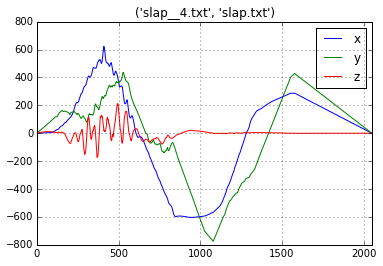

In [450]:
#k=convDict.keys()[19]
k = list(matches)[30]
#k = diagKeys[15]
df = convDict[ k ]
print k
print df.idxmax().to_string()
if (df.max()>0).any():
    print df.max().to_string()
df.plot(title=k)

In [452]:
def maxsum(df):
    return sum([ abs(x-y) for x in df.idxmax() for y in df.idxmax() ])

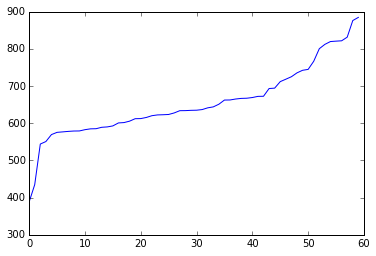

In [463]:
plt.plot(sorted([ convDict[k].max().max() for k in matches]))

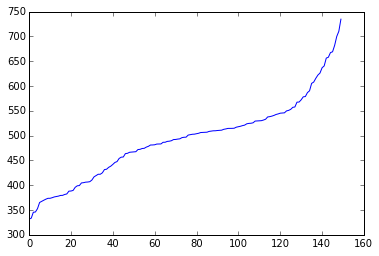

In [462]:
plt.plot(sorted([ convDict[k].max().max() for k in nonmatch]))

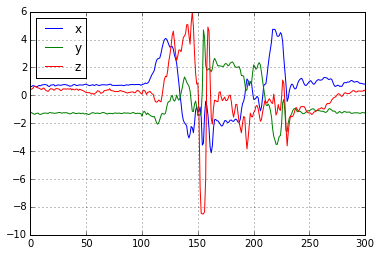